# Lecture 6d: Neural Network Learning Part 4

3/24/2023

## Using Keras Library:
 
 - Brain Tumor Detection
    - Brain Tumor Dataset Overview:
        The 'Brain Tumor Dataset' is a publicly available dataset with 3762 images of
        MRI brain scans with and without brain tumors. The goal of the dataset is to
        determine if a brain scan image shows a tumor or not.
        Source: https://www.kaggle.com/jakeshbohaju/brain-tumor

#### Class/labels: whether the image of the brain has a tumor (1) or not (0)
#### Features/attributes:
 - Mean: average of pixel values
 - Variance: width of histogram and how much gray levels deviate from the mean
 - Standard Deviation: average amount of variability in pixel values
 - Entropy: randomness of grayscale values
 - Skewness: quantifies histogram asymmetry around the mean
 - Kurtosis: quantifies sharpness of the histogram
 - Contrast: measures local level variations
 - Energy: intensity level of each pixel
 - ASM: measures image smoothness
 - Homogeneity: quantifies how low-contrast an image is
 - Dissimilarity: indicates the difference between pixels
 - Correlation: measures correlation between pixels in different directions
 - Coarseness: degree of microtexture in an image

#### Import Libraries:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical # Convert Class Vectors to Binary Class Matrices
from sklearn.preprocessing import MinMaxScaler

#### Function Definitions:

In [3]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

def plotDisplayMetrics(model, model_history):
    accuracy = np.array(model_history.history['accuracy'])
    loss = np.array(model_history.history['loss'])
    plotCurve(accuracy, loss)

    train_score = [accuracy[-1], loss[-1]]
    print(f'\nTraining Accuracy: {round(train_score[0], 5) * 100} %')
    print(f'Training Loss: {round(train_score[1], 4)}')

# Split Features and Labels from the Training DataFrame
def featuresLabelsSplit(data, labelColumnName):
    features = data.copy()
    columnTitles = list(data.columns)
    features = features.reindex(columns = columnTitles)
    labels = features.pop(labelColumnName)
    featureNames = list(features.columns)
    features = np.array(features)
    labels = np.array(labels)
    labels = labels.reshape((features.shape[0], 1))
    return features, labels, featureNames

# Split Features & Labels from Testing DataFrame
def featuresLabelsSplitTest(data, labelColumnName, featureNames):
    features = data.copy()
    columnTitles = list(data.columns)
    features = features.reindex(columns = columnTitles)
    labels = features.pop(labelColumnName)
    featuresSubset = np.zeros((labels.shape[0], 0))
    for column_i in featureNames:
        feature_i = np.expand_dims(features.pop(column_i), axis = 1)
        featuresSubset = np.append(featuresSubset, feature_i, axis = 1)
    labels = np.array(labels)
    labels = labels.reshape(features.shape[0], 1)
    return featuresSubset, labels

#### Import Training & Testing Data as DataFrames:

 - 1st column: `index_col` = index/row names.
 - 1st row: `header` = header/column names.

In [4]:
brain_tumor = pd.read_csv('../assets/Lecture6/BT-Training.csv', header=0, index_col=0)
brain_tumor_test = pd.read_csv('../assets/Lecture6/BT-Test.csv', header=0, index_col=0)

print(f'\nBrain Tumor Training Data:\nShape: {brain_tumor.shape}')
display(brain_tumor.head())

# brain_tumor_test

print(f'\nBrain Tumor Testing Data:\nShape: {brain_tumor_test.shape}')
display(brain_tumor_test.head())


Brain Tumor Training Data:
Shape: (3762, 14)


,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
Image,,,,,,,,,,,,,,
Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155



Brain Tumor Testing Data:
Shape: (1644, 18)


,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness,PSNR,SSIM,MSE,DC,Target
Image,,,,,,,,,,,,,,,,,,
Image1,23.448517,2538.985627,50.388348,0.651174,1.984202,5.421042,181.467713,0.781557,0.610831,0.847033,2.765411,0.968576,7.458341e-155,97.974630,0.777011,0.171163,0.303989,1
Image2,4.398331,834.853030,28.893823,0.953532,6.495203,43.349355,76.745886,0.972770,0.946281,0.980762,0.548605,0.959751,7.458341e-155,110.346597,0.977953,0.009913,0.839019,1
Image3,3.244263,642.059166,25.338886,0.966065,7.772860,61.756034,81.752406,0.980161,0.960715,0.985066,0.540411,0.944259,7.458341e-155,112.266298,0.985362,0.006372,0.849775,1
Image4,8.511353,1126.214187,33.559115,0.868765,3.763142,15.107579,362.291213,0.921786,0.849690,0.949295,2.765725,0.859027,7.458341e-155,101.955792,0.881015,0.068437,0.000000,0
Image5,21.000793,2235.316978,47.279139,0.684724,1.936029,4.722343,312.439226,0.804184,0.646711,0.880301,3.006660,0.938572,7.458341e-155,97.639870,0.766308,0.184878,0.000000,0


#### Drop Samples With Infinite or Empty Values:

In [5]:
brain_tumor_test = brain_tumor_test.replace([np.inf, -np.inf], np.nan).dropna(axis = 0)

#### Convert Training & Testing Data To Numpy Array Before Standardization:

In [6]:
train, test = brain_tumor, brain_tumor_test
classes = [0, 1]

trainArray = np.array(train)
testArray = np.array(test)
#print(trainArray, '\n')
#print(testArray, '\n')

#### Remove Excess Features From Test Set & Extract Labels For Train and Test:

 - Must Use A DataFrame In Split Function Argument.

In [7]:
trainData, trainLabels, featureNames = featuresLabelsSplit(train, 'Class')
testData, TestLabels = featuresLabelsSplitTest(test, 'Target', featureNames)

print(f'Total Samples = {len(trainArray) + len(testArray)}')
print(f'Testing Samples = {len(testArray)}')
print(f'Training Samples = {len(trainArray)}')

Total Samples = 5037
Testing Samples = 1275
Training Samples = 3762


#### Scale Data Values To Range $ [0, 1] $

 - Data Returned From `featuresLabelsSplit()` Functions.

In [8]:
scaler = MinMaxScaler()
trainDataScaled = scaler.fit_transform(trainData)
testDataScaled = scaler.transform(testData)

#### Convert Labels To Binary Class Matrix

 - Labels Returned from `featuresLabelsSplit()` functions
 - This Conversion Only Needed For `softmax` Output Layer Activation

In [9]:
trainLabelsCat = to_categorical(trainLabels, len(classes))
testLabelsCat = to_categorical(TestLabels, len(classes))

#### Define The Model:

In [11]:
model5 = Sequential()
model5.add(Dense(input_dim = 13, units = 64, activation = 'relu')) # 13 Features as Inputs
model5.add(Dense(units = 128, activation = 'relu'))
model5.add(Dense(units = 64, activation = 'relu'))
model5.add(Dense(units = len(classes), activation = 'softmax')) # Can Also Use Sigmoid
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                896       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,602
Trainable params: 17,602
Non-trainable params: 0
_________________________________________________________________


#### Compile, Fit & Evaluate The Model:

Epoch 1/50
59/59 [==============================] - 1s 1ms/step - loss: 0.6815 - accuracy: 0.6154
Epoch 2/50
59/59 [==============================] - 0s 991us/step - loss: 0.6398 - accuracy: 0.6404
Epoch 3/50
59/59 [==============================] - 0s 1ms/step - loss: 0.5734 - accuracy: 0.8743
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.4688 - accuracy: 0.9375
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.3428 - accuracy: 0.9556
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2344 - accuracy: 0.9604
Epoch 7/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.9657
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1272 - accuracy: 0.9716
Epoch 9/50
59/59 [==============================] - 0s 993us/step - loss: 0.1059 - accuracy: 0.9758
Epoch 10/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9782
Epoch 11/50
59/

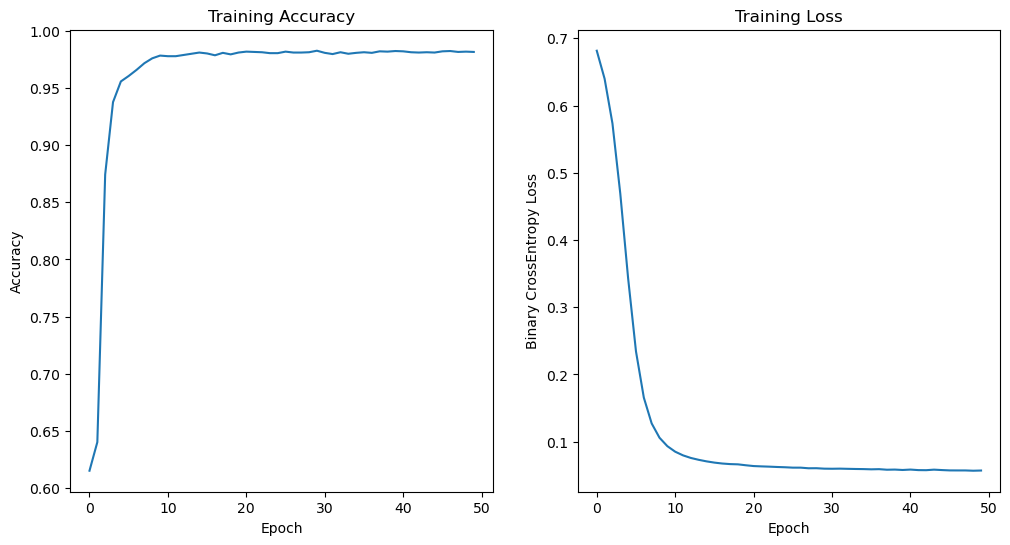


Training Accuracy: 98.139 %
Training Loss: 0.0571


In [12]:
opt5 = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model5.compile(optimizer = opt5, loss = 'binary_crossentropy', metrics = ['accuracy'])
history5 = model5.fit(trainDataScaled, trainLabelsCat, epochs = 50, batch_size = 64, verbose = 1)

plotDisplayMetrics(model5, history5)

#### Evaluate The Model With The Testing Data:

In [14]:
testScore = model5.evaluate(testDataScaled, testLabelsCat)

print(f'\nTest Set Accuracy: {round(testScore[1], 5) * 100} %')
print(f'Testing Loss: {round(testScore[0], 4)}')

40/40 [==============================] - 0s 913us/step - loss: 15.4227 - accuracy: 0.1114

Test Set Accuracy: 11.137 %
Testing Loss: 15.4227


Note that this model performs poorly on the test data due to overfitting during training.

Overfitting results in low scores on unseen data.

This model does not generalize well.